Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [5]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [6]:
import pickle
FN0 = 'data_lists' # this is the name of the data file which I assume you already have
with open('data/%s.pickle'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [7]:
if lower:
    heads = [h.lower() for h in heads]

In [8]:
if lower:
    desc = [h.lower() for h in desc]

In [9]:
i=0
heads[i]

'agent cooper in twin peaks is the audience : once delighted , now disintegrating'

In [10]:
desc[i]

'and never more so than in showtime ’ s new series revival some spoilers ahead through episode 4 of season 3 of twin peaks . on may 21st , showtime brought back david lynch ’ s groundbreaking tv series twin peaks , and fulfilled a prophecy in the process . in the second season finale , back in 1991 , the spirit of series-defining murder victim laura palmer told fbi special agent and series protagonist dale cooper , “ i ’ ll see you again in 25 years. ” that clip plays again in the first episode of lynch ’ s twin peaks revival , as a reminder that decades have in fact gone by , laura ’ s promise has been carried out , and a series canceled mid-story is back on the air . a lot has changed in 25 years .'

In [11]:
#keywords[i]

In [12]:
len(heads),len(set(heads))

(173028, 172944)

In [13]:
len(desc),len(set(desc))

(173028, 169687)

# build vocabulary

In [14]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [15]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [16]:
print(vocab[:50])
print('...',len(vocab))

[',', 'the', '.', 'to', 'of', 'a', 'and', 'in', '’', 'that', 'on', 'for', 's', 'is', '“', '”', 'with', 'was', 'it', 'as', 'at', 'trump', 'he', '``', "'s", 'his', 'by', 'from', ':', 'an', 'has', 'said', 'new', '[', '—', 'be', 'have', "'", 'are', 'this', "''", 'who', 'i', 'but', 'not', 'they', 'about', '-', 'after', '(']
... 289580


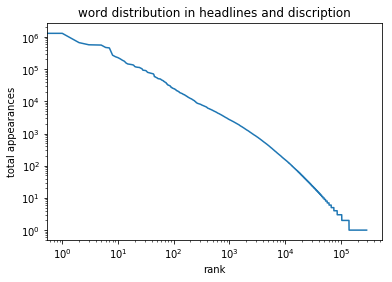

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [18]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [19]:
def get_idx(voca, vocabc):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(voca))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [20]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [21]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
import keras.utils as utils
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = utils.get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

Using TensorFlow backend.


In [22]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [25]:
import numpy as np

glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r', encoding="utf-8") as fp:
    i = 0
    for l in fp.readlines():
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = [float(x) for x in l[1:]]
        i += 1
glove_embedding_weights *= globale_scale

In [26]:
glove_embedding_weights.std()

0.04081572760019029

In [27]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [29]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 36208 0.9052


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [30]:
glove_thr = 0.5

In [31]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [34]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 61178


manually check that the worst substitutions we are going to do are good enough

In [36]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.5000164774472091 ibe => gyasi
0.5000116509364403 getz => saxophonist
0.5000113821651962 moneymaker => doozy
0.5000092035657678 cq => deletes
0.5000089661535665 vilma => pineda
0.5000085715859812 philo => cyrus
0.5000079261602683 mandan => chol
0.5000069905641444 terada => kislyak
0.5000057963554322 lacerta => westworld
0.5000055595011661 cheapskate => dude


build a lookup table of index of outside words to index of inside words

In [37]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [38]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

173028

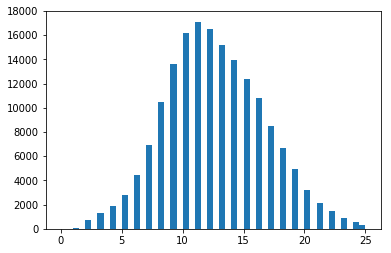

In [40]:
plt.hist(list(map(len,Y)),bins=50);

In [41]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

173028

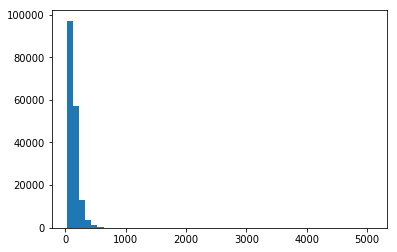

In [42]:
plt.hist(list(map(len,X)),bins=50);

In [44]:
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [45]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)